# Truncated Skewed Levy Distribution

In [2]:
from levy_distribution import pdf_from_cf, dump_levy, load_levy, kde_fit_levy
import matplotlib.pyplot as plt
import numpy as np
import time
from scipy.stats import gaussian_kde
import pandas as pd
from arch import arch_model

## Training data

In [3]:
dfs = pd.read_excel('../Indices_Data.xlsx', sheet_name=None)

euronext100 = dfs['Euronext100'][['Date', 'Close']]
stoxx50e = dfs['Stoxx50E'][['Date', 'Close']]
snp500 = dfs['S&P500'][['Date', 'Close']]
data = snp500.copy()
data = data[(data['Date'] > '2006-01-01') & (data['Date'] < '2017-12-31')].reset_index()

data['Returns'] = np.log(data['Close'] / data['Close'].shift(1))*100
data['10 Days Returns'] = data['Returns'].rolling(window=10).sum()
data['210 Days Returns'] = data['Returns'].rolling(window=210).sum()
data = data.iloc[251:].reset_index()

In [4]:
print(data[['Date','Returns']])

           Date   Returns
0    2007-01-03 -0.119939
1    2007-01-04  0.122753
2    2007-01-05 -0.610317
3    2007-01-08  0.221786
4    2007-01-09 -0.051681
...         ...       ...
2764 2017-12-22 -0.045827
2765 2017-12-26 -0.105898
2766 2017-12-27  0.079063
2767 2017-12-28  0.183232
2768 2017-12-29 -0.519663

[2769 rows x 2 columns]


## Fit the Garch
The Garch model:

In [5]:
def model(returns : pd.DataFrame, omega, alpha, gamma, beta, kappa):
    t_max = len(returns)
    epsilon = np.zeros(t_max)
    sigma = np.zeros(t_max+1)

    sigma[0]= returns.std()
    
    for t in range(t_max):
        if returns[t]<0:
            leverage=1
        else:
            leverage=0
        epsilon[t] = returns[t]/sigma[t]
        sigma[t+1] = np.power(omega + alpha*np.power(np.abs(epsilon[t]),kappa)+gamma*leverage*np.power(np.abs(epsilon[t]),kappa)+beta*np.power(sigma[t],kappa), 1/kappa)
    return sigma

In [6]:
garch = arch_model(data['Returns'], p=1, q=1, o=1, power=1.76, dist='normal')
results=garch.fit()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 45073776.72837777
Iteration:      2,   Func. Count:     16,   Neg. LLF: 3206652419.0222716
Iteration:      3,   Func. Count:     25,   Neg. LLF: 3795.577197006219
Iteration:      4,   Func. Count:     32,   Neg. LLF: 3688.451477282945
Iteration:      5,   Func. Count:     39,   Neg. LLF: 9431.269747781098
Iteration:      6,   Func. Count:     47,   Neg. LLF: 3685.918016514541
Iteration:      7,   Func. Count:     54,   Neg. LLF: 3683.1272848367907
Iteration:      8,   Func. Count:     60,   Neg. LLF: 3683.12225352771
Iteration:      9,   Func. Count:     67,   Neg. LLF: 3683.1044010797277
Iteration:     10,   Func. Count:     73,   Neg. LLF: 3683.1037852779145
Iteration:     11,   Func. Count:     78,   Neg. LLF: 3683.103785280225
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3683.1037852779145
            Iterations: 11
            Function evaluations: 78
            Gradient evaluations

In [7]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
               Constant Mean - Asym. Power GARCH (power: 1.8) Model Results               
==========================================================================================
Dep. Variable:                            Returns   R-squared:                       0.000
Mean Model:                         Constant Mean   Adj. R-squared:                  0.000
Vol Model:         Asym. Power GARCH (power: 1.8)   Log-Likelihood:               -3683.10
Distribution:                              Normal   AIC:                           7376.21
Method:                        Maximum Likelihood   BIC:                           7405.84
                                                    No. Observations:                 2769
Date:                            Thu, Mar 27 2025   Df Residuals:                     2768
Time:                                    14:13:56   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0263  1.466e-02      1.792  7.309e-02 [-2.458e-03,5.501e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0247  5.356e-03      4.605  4.124e-06  [1.417e-02,3.516e-02]
alpha[1]       0.0000  2.057e-02      0.000      1.000 [-4.032e-02,4.032e-02]
gamma[1]       0.2059  3.003e-02      6.858  7.000e-12      [  0.147,  0.265]
beta[1]        0.8818  1.835e-02     48.043      0.000      [  0.846,  0.918]
=============================================================================

Covariance estimator: robust
"""

In [8]:
print(results.params)

mu          0.026274
omega       0.024663
alpha[1]    0.000000
gamma[1]    0.205948
beta[1]     0.881810
Name: params, dtype: float64


In [9]:
mean = results.params['mu']
std_dev = model(data['Returns'],omega=results.params['omega'],alpha=results.params['alpha[1]'],gamma = results.params['gamma[1]'], beta=results.params['beta[1]'], kappa=1.76)

In [10]:
data['Standardized Returns'] = (data['Returns']-mean)/std_dev[:-1]
data['Volatilities'] = std_dev[:-1]

In [11]:
kde= gaussian_kde(data['Standardized Returns'])
x_values = np.linspace(-5,5,1000)
y_kde=kde(x_values)

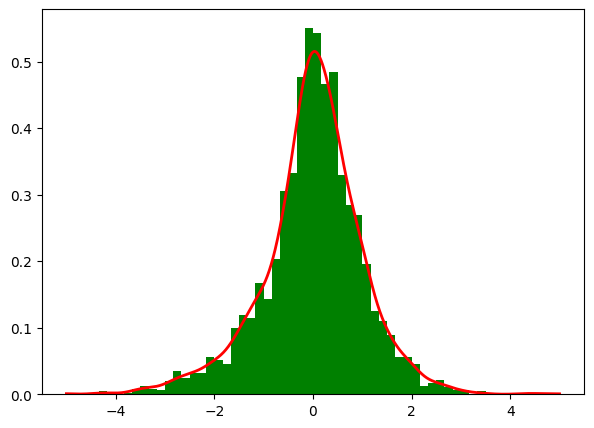

In [12]:
plt.figure(figsize=(7, 5))
plt.hist(data['Standardized Returns'], range=(-5, 5), bins=60, density=True, color='green')
plt.plot(x_values,y_kde, color='red', linewidth = 2)
plt.show()

## KDE Fit the PDF
On the standardized normal

In [13]:
n_points = 9
alpha_grid = np.linspace(0.75,0.81,n_points)
lam_grid = np.linspace(1.60,1.80,n_points)
beta_grid = np.linspace(-0.12,-0.18,n_points)

In [14]:
kde_opt = kde_fit_levy(data['Standardized Returns'],alpha_grid=alpha_grid, lam_grid=lam_grid, beta_grid=beta_grid, n = 100, x_max=15, k_max=15.0, ln_2_k_points=10)

In [15]:
print(kde_opt)

[ 0.765  1.675 -0.165]


In [16]:
x_values = np.linspace(-5, 5, 1000)
start_time = time.time()
y_values = pdf_from_cf(x_values, 0, 1, kde_opt[0], kde_opt[1], kde_opt[2], k_max=15.0, ln_2_k_points=12, x_lim=25)
print("It took %s seconds for 1000 evaluations" % (time.time() - start_time))

It took 0.5852282047271729 seconds for 1000 evaluations


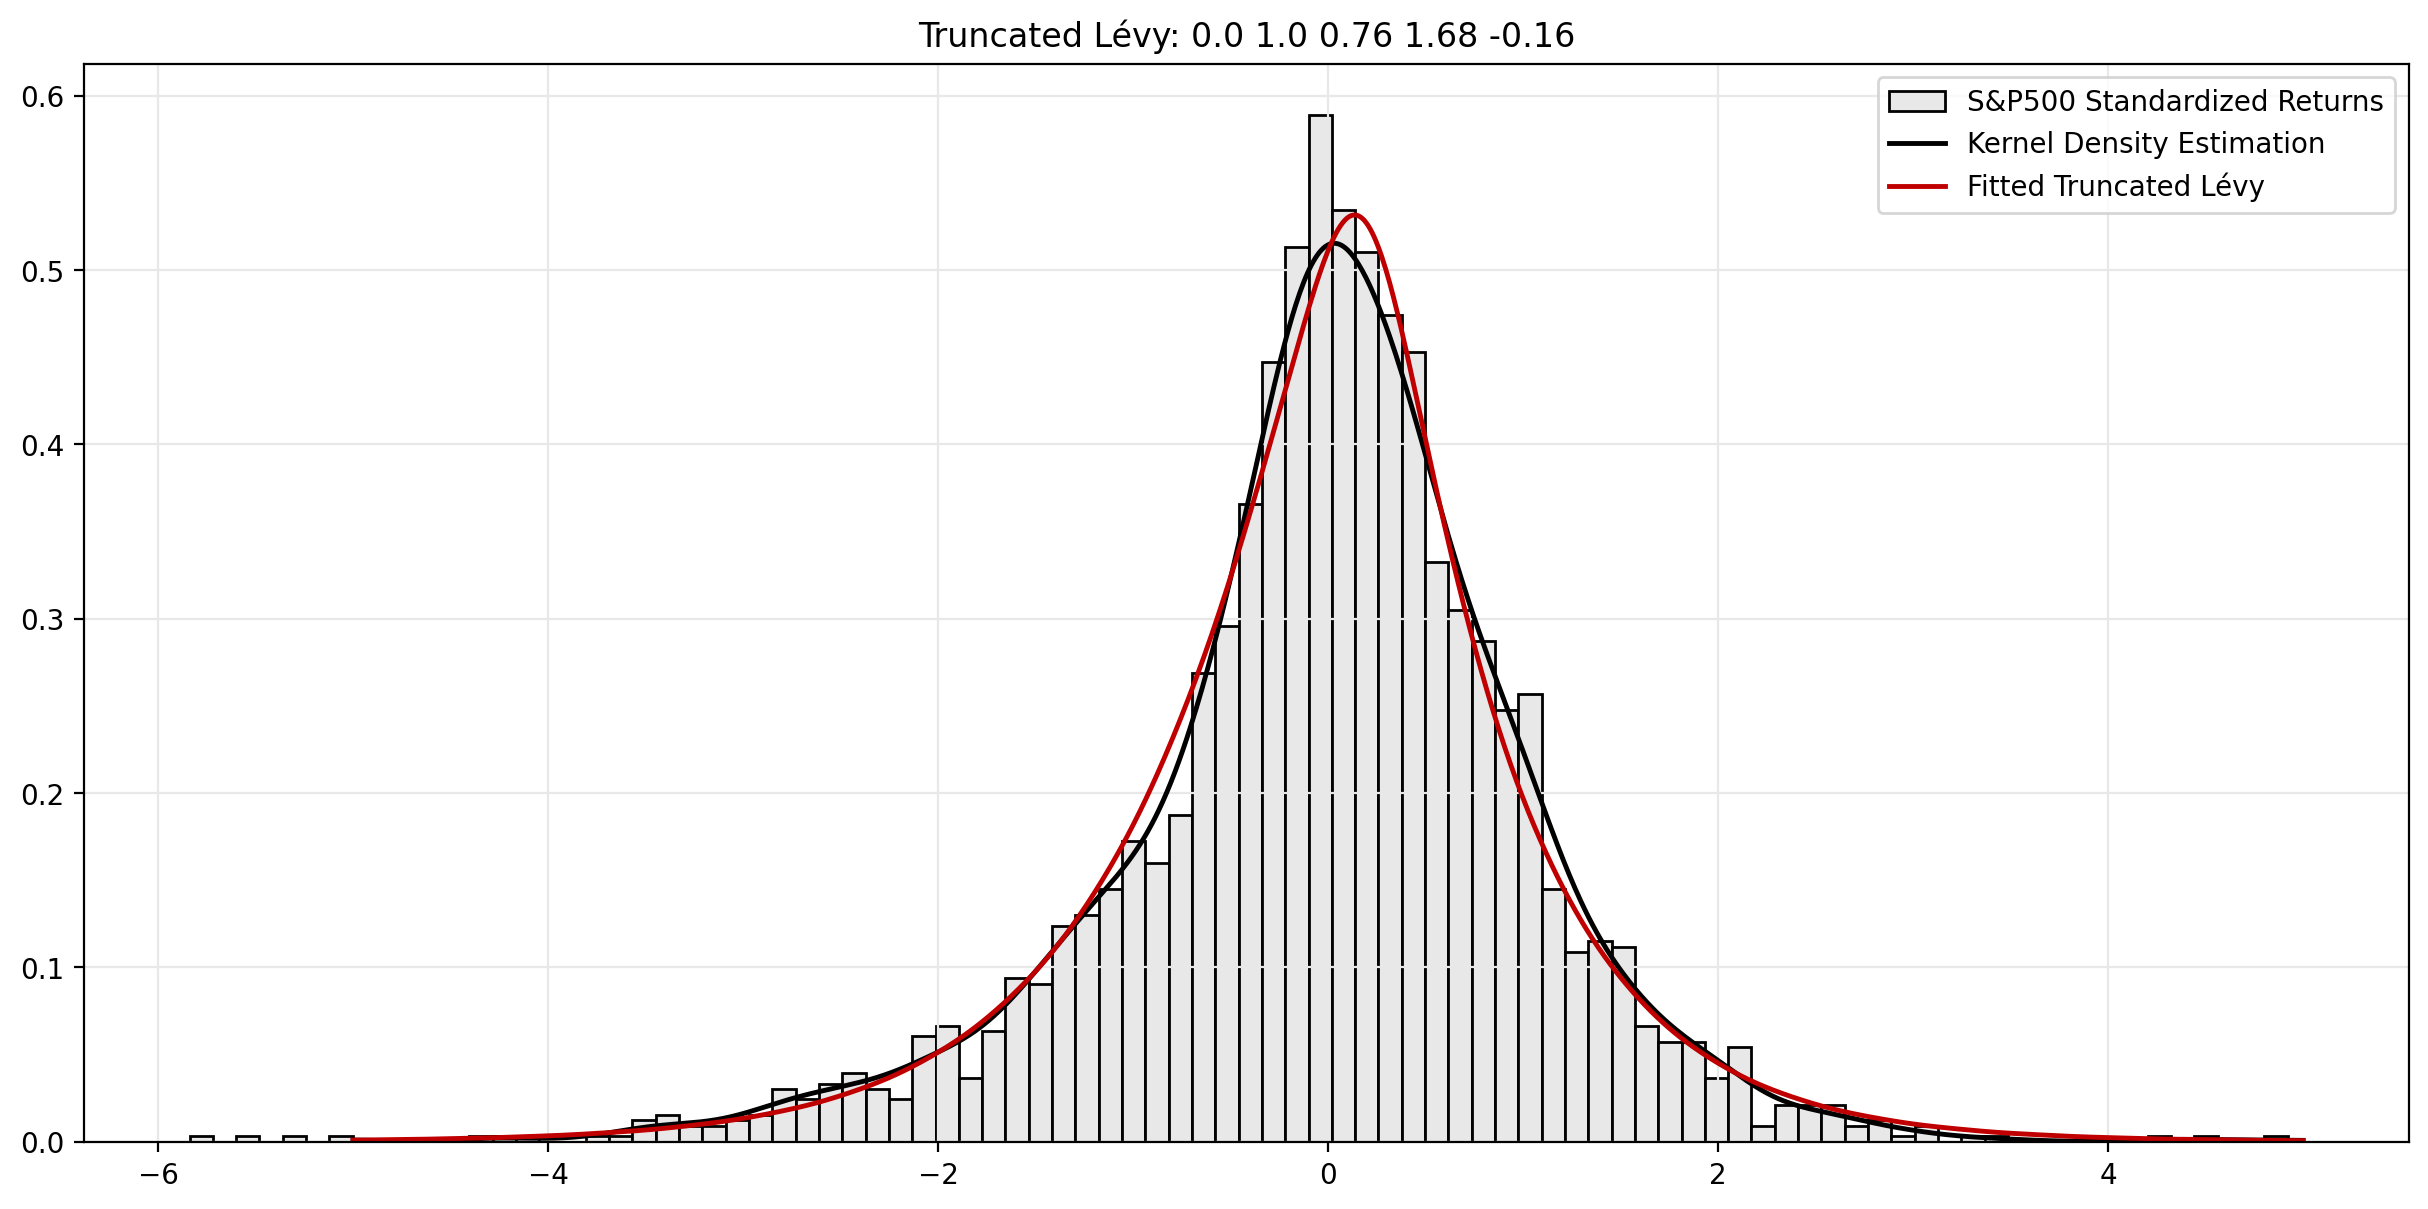

In [17]:
fig, ax = plt.subplots(figsize=(15,7), facecolor = 'white',dpi=200)
ax.grid(color='#E8E8E9', linestyle='-', linewidth=0.8)
ax.hist(data['Standardized Returns'], bins=90, density=True, color='#E8E8E8', edgecolor='#000000', label='S&P500 Standardized Returns')
ax.plot(x_values, y_kde, label='Kernel Density Estimation', color='#000000', linewidth=1.75)
ax.plot(x_values, y_values, label='Fitted Truncated Lévy', color='#C00000', linewidth=1.75)

ax.legend()

#sns.despine(ax=ax, left=True, bottom=True)

ax.set_title("Truncated Lévy: " + str(np.round(0.00,2)) + ' ' +  str(np.round(1.00,2)) + ' ' +   str(np.round(kde_opt[0],2)) + ' ' +   str(np.round(kde_opt[1],2)) + ' ' +   str(np.round(kde_opt[2],2)))

plt.show()

## Save the distribution points

In [18]:
# dump_levy(0,1,kde_opt[0],kde_opt[1],kde_opt[2],x_min=-20,x_max=20,x_points=40000,k_max=50,ln_2_k_points=15)

In [19]:
levy=load_levy('truncated_levy_0_1_0.76_1.68_-0.16.npz')

## VaR Calculation

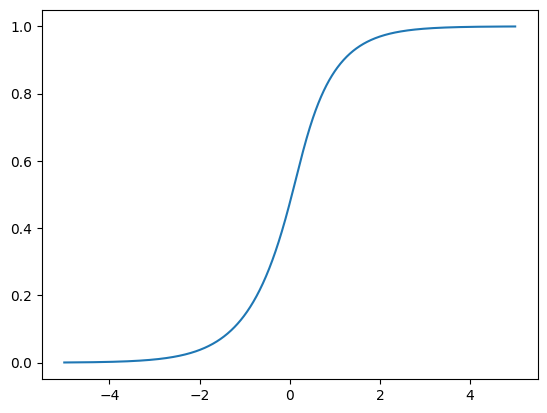

In [20]:
x = np.linspace(-5,5,1000)
y = levy.cdf(x)
plt.plot(x,y)
plt.show()

In [21]:
first_percentile = levy.ppf(0.01, loc=0.0, scale=1.0)
print(first_percentile)

-2.962705133886335


In [22]:
data['1 Day VaR'] = first_percentile*data['Volatilities']

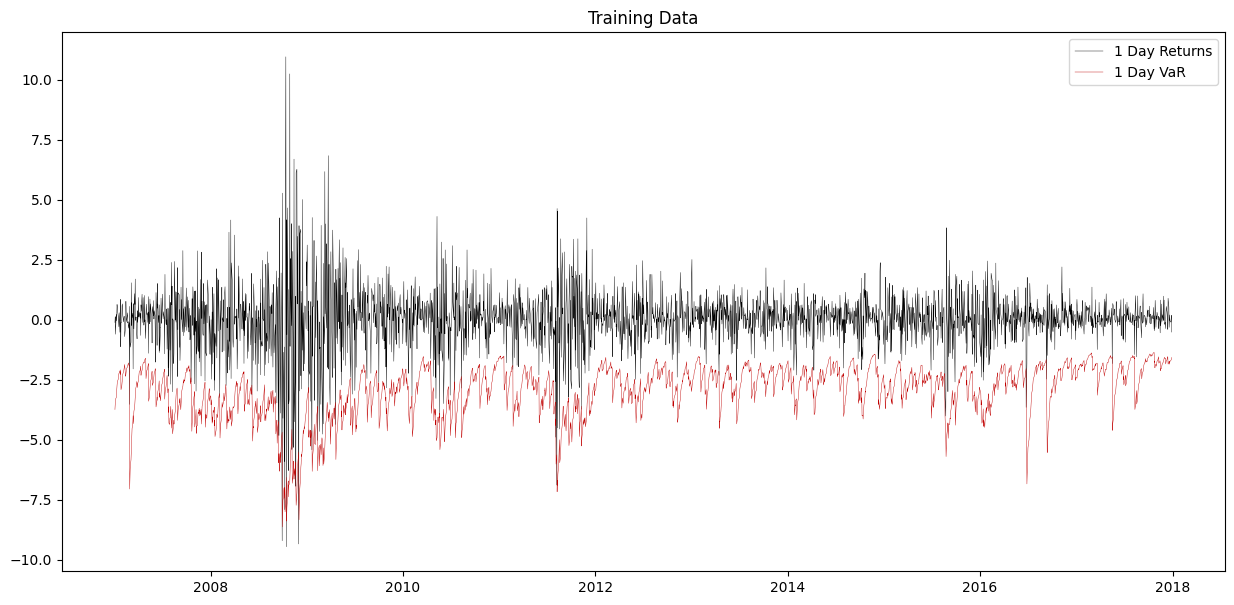

In [23]:
plt.figure(figsize=(15,7))
plt.plot(data['Date'],data['Returns'],label='1 Day Returns', color='black',linewidth = 0.3)
plt.plot(data['Date'],data['1 Day VaR'],label='1 Day VaR', color = '#C00000', linewidth = 0.3)
plt.title('Training Data')
plt.legend()
plt.show()

In [24]:
data['Violations']=data['1 Day VaR'] > data['Returns']

In [25]:
violations=data['Violations'].mean()*100

In [26]:
print(violations,'%')

0.9389671361502347 %


## Test Data

In [27]:
test_data= snp500.copy()
test_data = test_data[(test_data['Date'] > '2017-12-31') & (test_data['Date'] < '2024-12-31')].reset_index()
test_data['Returns'] = np.log(test_data['Close'] / test_data['Close'].shift(1)) * 100
test_data = test_data.dropna().reset_index()

In [28]:
test_data['Returns']

0       0.637843
1       0.402054
2       0.700915
3       0.166096
4       0.130208
          ...   
1754    0.726085
1755    1.098223
1756   -0.040574
1757   -1.111730
1758   -1.075967
Name: Returns, Length: 1759, dtype: float64

In [29]:
mean = results.params['mu']
test_std_dev = model(test_data['Returns'],omega=results.params['omega'],alpha=results.params['alpha[1]'],gamma = results.params['gamma[1]'], beta=results.params['beta[1]'], kappa=1.76)

In [30]:
test_std_dev

array([1.24756613, 1.17397503, 1.10604268, ..., 1.3508274 , 1.33729651,
       1.3226579 ])

In [31]:
test_data['Standardized Returns'] = (test_data['Returns']-mean)/test_std_dev[:-1]
test_data['Volatilities'] = test_std_dev[:-1]
test_data['1 Day VaR'] = first_percentile * test_data['Volatilities']
test_data['Violations'] = test_data['1 Day VaR'] > test_data['Returns']
test_violations=test_data['Violations'].mean()*100

In [32]:
print(test_violations)

1.023308698123934


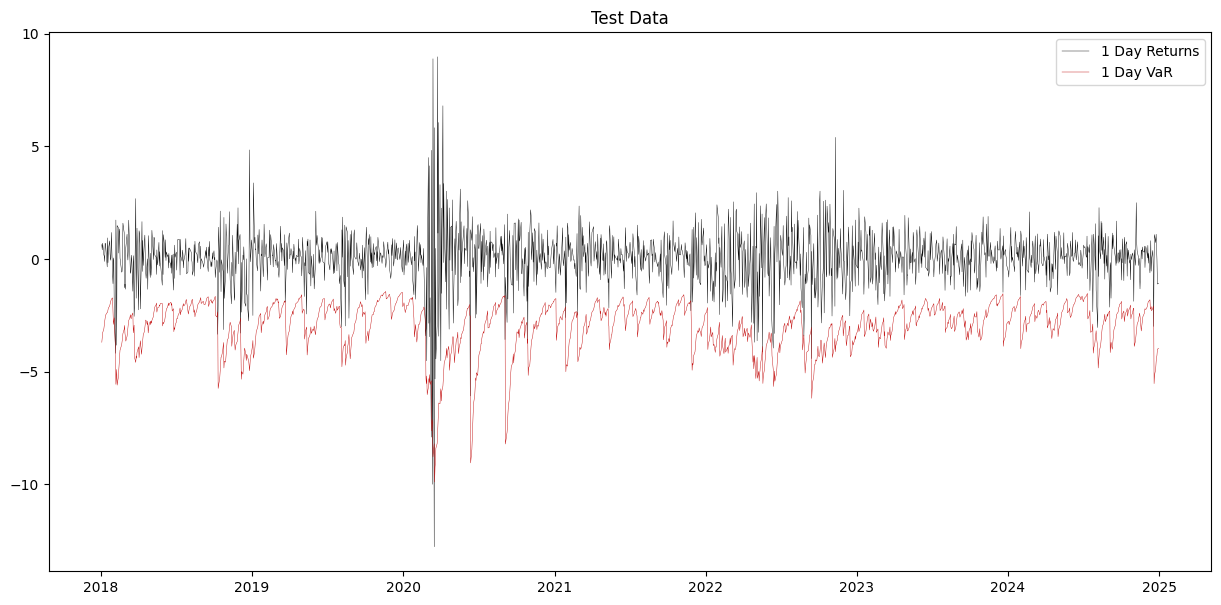

In [33]:
plt.figure(figsize=(15,7))
plt.plot(test_data['Date'],test_data['Returns'],label='1 Day Returns', color='black',linewidth = 0.3)
plt.plot(test_data['Date'],test_data['1 Day VaR'],label='1 Day VaR', color = '#C00000', linewidth = 0.3)
plt.title('Test Data')
plt.legend()
plt.show()

# Scaling to 10 Days VaR

In [43]:
x = np.linspace(-10,10,1000)
mu = 0.0
c = 1.0
alpha = kde_opt[0]
lamb = kde_opt[1]
beta = kde_opt[2]

N = 10.0
N_alpha = N**(1/alpha)
print(N_alpha)
y = pdf_from_cf(x/N_alpha,mu,c,alpha,lamb*N_alpha,beta,x_lim=50,k_max=50,ln_2_k_points=15)/N_alpha

20.285678698408102


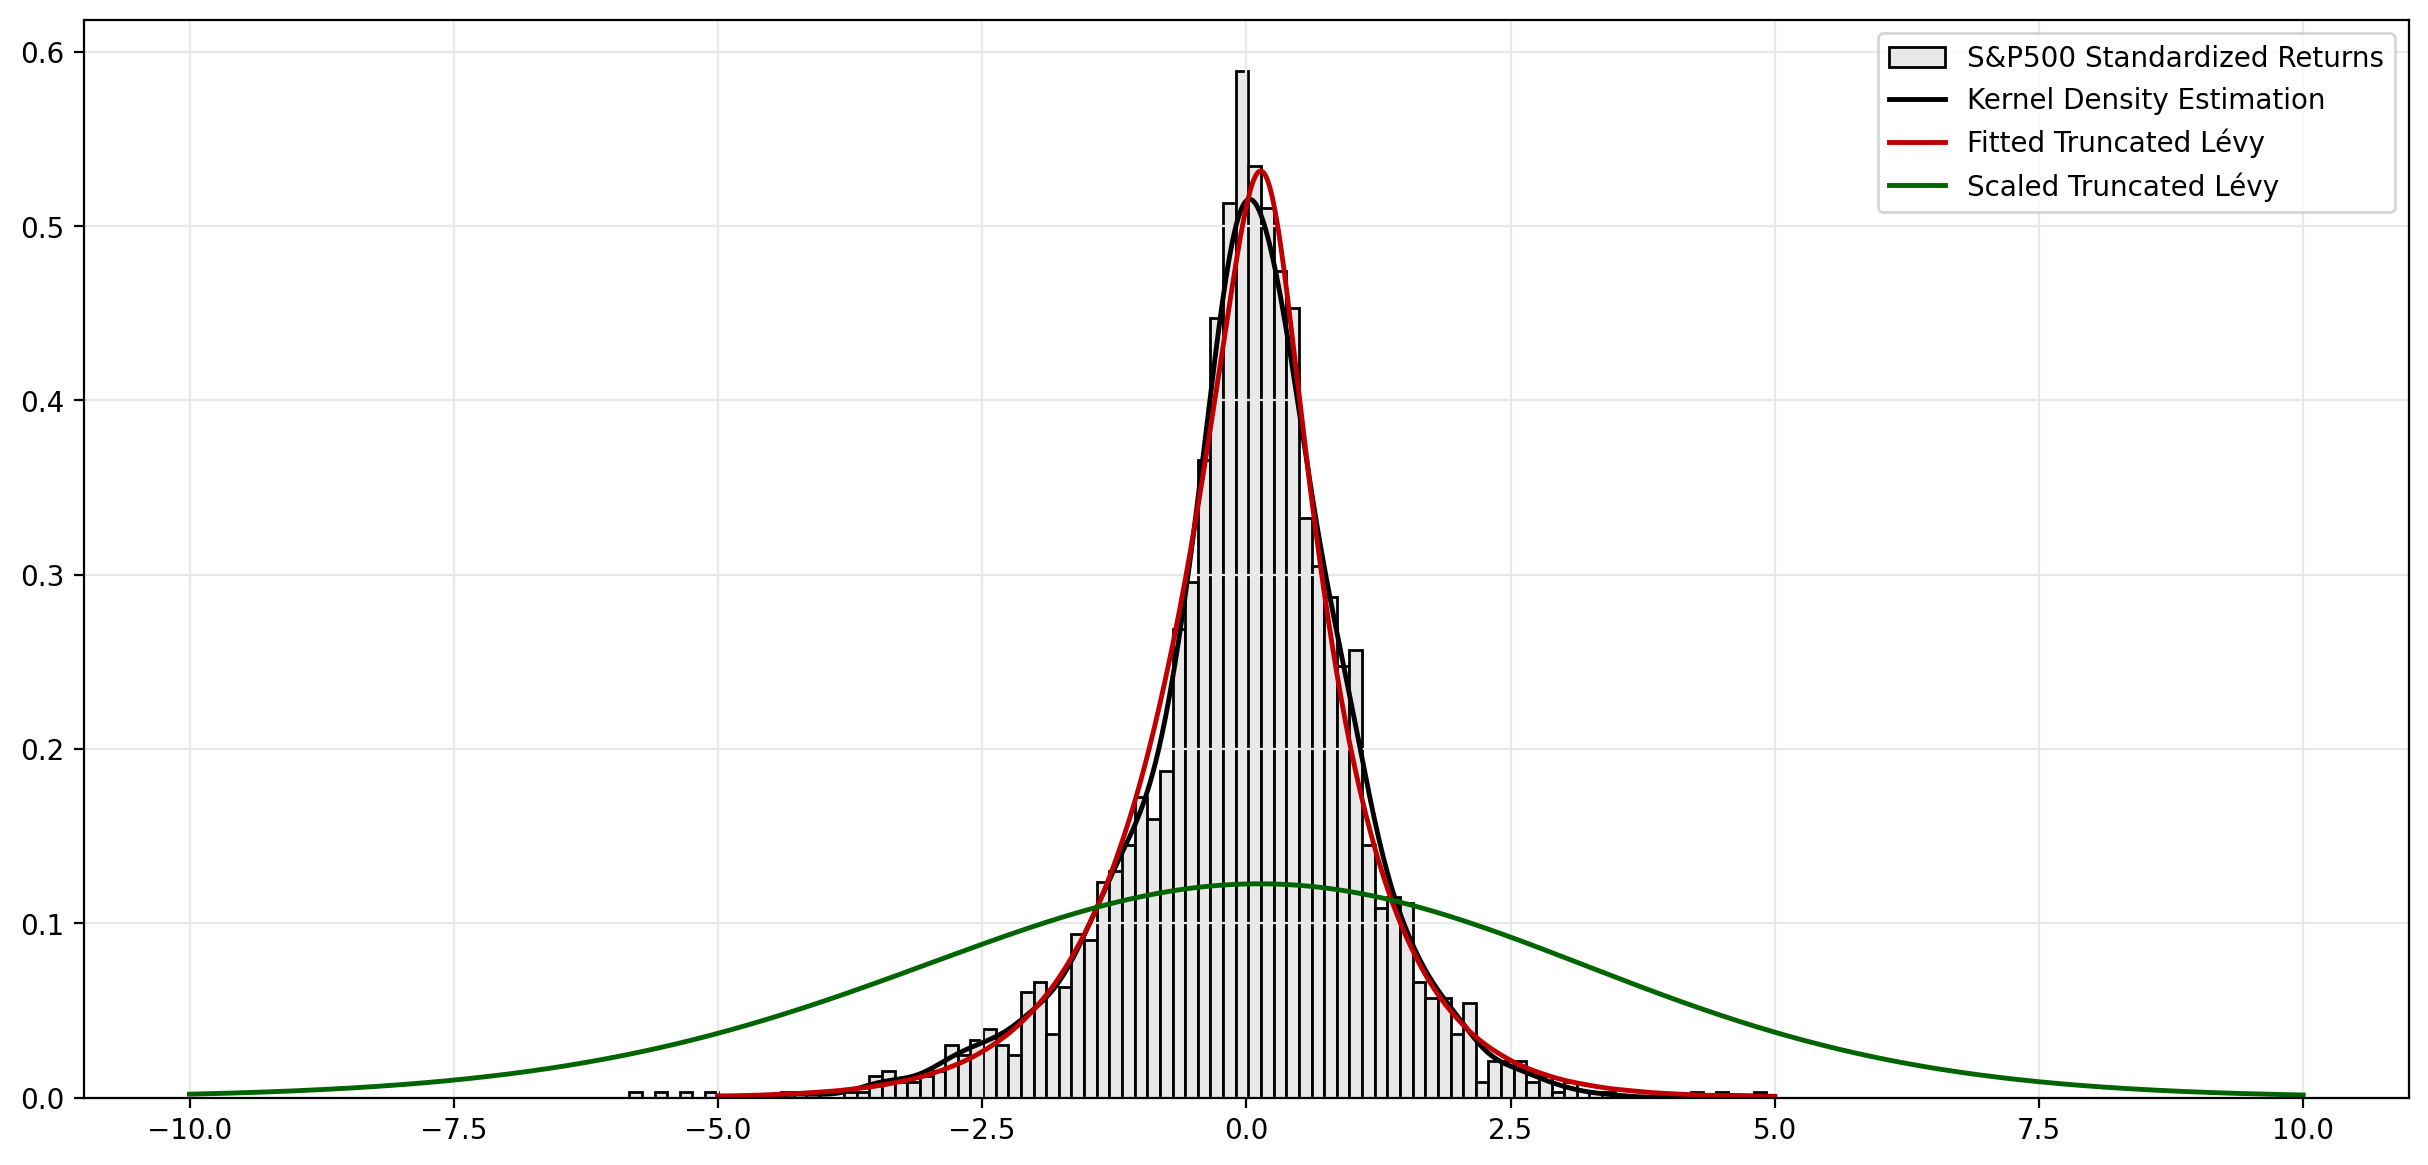

In [44]:
fig, ax = plt.subplots(figsize=(15,7), facecolor = 'white',dpi=200)
ax.grid(color='#E8E8E9', linestyle='-', linewidth=0.8)
ax.hist(data['Standardized Returns'], bins=90, density=True, color='#E8E8E8', edgecolor='#000000', label='S&P500 Standardized Returns')
ax.plot(x_values, y_kde, label='Kernel Density Estimation', color='#000000', linewidth=1.75)
ax.plot(x_values, y_values, label='Fitted Truncated Lévy', color='#C00000', linewidth=1.75)
ax.plot(x, y, label='Scaled Truncated Lévy', color='#006400', linewidth=1.75)
ax.legend()
plt.show()

In [ ]:
from scipy_distribution import dump_distribution

def dump_scaled_levy(loc, scale, alpha, lam, beta,N, filename='truncated_levy', x_min=-15, x_max =15, x_points=10000, k_max=50.0, ln_2_k_points=15):
    N_alpha = N ** (1 / alpha)
    y = pdf_from_cf(x / N_alpha, mu, c, alpha, lamb * N_alpha, beta, x_lim=50, k_max=50, ln_2_k_points=15) / N_alpha
    x_values = np.linspace(x_min,x_max,x_points)
    pdf_values = pdf_from_cf(x_values,loc, scale, alpha, lam, beta,k_max=k_max, ln_2_k_points=ln_2_k_points)
    filename = filename + '_' + str(np.round(loc,2)) + '_' +  str(np.round(scale,2)) + '_' +   str(np.round(alpha,2)) + '_' +   str(np.round(lam,2)) + '_' +   str(np.round(beta,2))
    dump_distribution(x_vals=x_values,pdf_vals=pdf_values,filename=filename)
    return filename

# Not Working: Fitting 10 Days returns

In [ ]:
biweekly_garch = arch_model(data['10 Days Returns'], p=1, q=1, o=1, power=1.76, dist='normal')
biweekly_results=biweekly_garch.fit()

In [ ]:
biweekly_results.summary()

In [ ]:
biweekly_mean = biweekly_results.params['mu']
biweekly_std_dev = model(data['10 Days Returns'],omega=biweekly_results.params['omega'],alpha=biweekly_results.params['alpha[1]'],gamma = biweekly_results.params['gamma[1]'], beta=biweekly_results.params['beta[1]'], kappa=1.76)

In [ ]:
data['Standardized 10 Days Returns'] = (data['10 Days Returns']-biweekly_mean)/biweekly_std_dev[:-1]
data['10 Days Volatilities'] = biweekly_std_dev[:-1]

In [ ]:
n_points = 29
alpha_grid = np.linspace(0.67,0.67,1)
lam_grid = np.linspace(0.01,0.29,7)
beta_grid = np.linspace(-0.89,0.09,13)

In [ ]:
biweekly_kde_opt = kde_fit_levy(data['Standardized 10 Days Returns'],alpha_grid=alpha_grid, lam_grid=lam_grid, beta_grid=beta_grid, n = 300, x_max=10, k_max=15.0, ln_2_k_points=11)

In [ ]:
print(biweekly_kde_opt)

In [ ]:
x_biweekly_values = np.linspace(-5, 5, 1000)
start_time = time.time()
y_biweekly_values = pdf_from_cf(x_biweekly_values, 0, 3, biweekly_kde_opt[0], biweekly_kde_opt[1], biweekly_kde_opt[2], k_max=15.0, ln_2_k_points=12, x_lim=15)
print("It took %s seconds for 1000 evaluations" % (time.time() - start_time))

biweekly_kde = gaussian_kde(data['Standardized 10 Days Returns'])
y_biweekly_kde = biweekly_kde(x_biweekly_values)

In [ ]:
fig, ax = plt.subplots(figsize=(15,7), facecolor = 'white',dpi=200)
ax.grid(color='#E8E8E9', linestyle='-', linewidth=0.8)
ax.hist(data['Standardized 10 Days Returns'], bins=70, density=True, color='#E8E8E8', edgecolor='#000000', label='S&P500 Standardized Returns')
ax.plot(x_biweekly_values, y_biweekly_kde, label='Kernel Density Estimation', color='#000000', linewidth=1.75)
ax.plot(x_biweekly_values, y_biweekly_values, label='Fitted Truncated Lévy', color='#C00000', linewidth=1.75)
ax.legend()

ax.set_title("Truncated Lévy: " + str(np.round(0.00,2)) + ' ' +  str(np.round(1.00,2)) + ' ' +   str(np.round(biweekly_kde_opt[0],2)) + ' ' +   str(np.round(biweekly_kde_opt[1],2)) + ' ' +   str(np.round(biweekly_kde_opt[2],2)))

plt.show()